In [16]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

In [17]:
df = pd.read_csv('data/final_combined_dataset.csv')

In [18]:
# geocode_list = [3303807]
# df = df[df['geocode'].isin(geocode_list)]

In [19]:
df['week'] = pd.to_numeric(df['week'], errors='coerce')
df['date'] = pd.to_datetime(df['date'])

# Add date_ordinal
df['date_ordinal'] = df['date'].apply(lambda x: x.toordinal())

# Extract year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# sum of cases each year
cases_sum = df.groupby(['year'])['cases'].sum().reset_index()

print(cases_sum)

# Add cyclic month representation
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Add cyclic week representation
df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)

    year   cases
0   2012  254010
1   2013  256911
2   2014   15150
3   2015   94824
4   2016  112646
5   2017   17257
6   2018   25184
7   2019   50378
8   2020    8021
9   2021    5445
10  2022   23100


In [20]:
selected_columns = [
    "cases",
    "week",
    "geocode",
    "cases_per_100k",
    "vim",
    "week_sin",
    "week_cos",
    "month_sin",
    "month_cos",
    "temp_avg",
    "humidity_avg",
    "precipitation_avg_ordinary_kriging",
]

df = df[selected_columns]

In [21]:
# Step 2: Create lag features
def create_lags(dataframe, group_col, target_col, lags, inplace = False):
    if isinstance(target_col, list):  # If target_col is a list of columns
        for col in target_col:
            for lag in lags:
                if inplace:
                    dataframe[target_col] = dataframe.groupby(group_col)[col].shift(lag)
                else:
                    dataframe[f'{col}_lag{lag}'] = dataframe.groupby(group_col)[col].shift(lag)
    else:  # If target_col is a single column
        for lag in lags:
            if inplace:
                dataframe[target_col] = dataframe.groupby(group_col)[target_col].shift(lag)
            else:
                dataframe[f'{target_col}_lag{lag}'] = dataframe.groupby(group_col)[target_col].shift(lag)
    return dataframe

# Lag cases by 1 and 2 weeks
data = create_lags(df, group_col='geocode', target_col='cases', lags=[0, 1])

# Lag weather-related variables by 5 and 6 weeks for each geocode
weather_columns = ['precipitation_avg_ordinary_kriging']
data = create_lags(data, group_col='geocode', target_col=weather_columns, lags=[3, 4])

# data = create_lags(data, group_col='geocode', target_col='nearby_cases_weighted', lags=[4])

# lag cases -4 weeks
data = create_lags(data, group_col='geocode', target_col='cases', lags=[-2], inplace = True)

data = data.dropna().reset_index(drop=True)

In [22]:
# Step 4: Scale continuous variables, including lagged variables
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

continuous_vars = ['cases_per_100k', 'temp_avg', 'humidity_avg', "precipitation_avg_ordinary_kriging"]
lagged_vars = [col for col in data.columns if '_lag' in col]

# Filter scaler_vars to only include variables that are in data.columns
scaler_vars = [col for col in continuous_vars + lagged_vars if col in data.columns]

# remove weather columns from scaler_vars
scaler_vars.remove('precipitation_avg_ordinary_kriging')

In [23]:
# Step 5: Split the data into training and testing sets based on time
train_data = data[(data['week'] >= 201201) & (data['week'] <= 201853)]
test_data = data[(data['week'] > 201853)]

columns_exclude = ['cases', 'precipitation_avg_ordinary_kriging']

X_train = train_data[[col for col in data.columns if col not in columns_exclude]]
y_train = train_data['cases']

X_test = test_data[[col for col in data.columns if col not in columns_exclude]]
y_test = test_data['cases']

X_train.loc[:, scaler_vars] = feature_scaler.fit_transform(X_train[scaler_vars])
X_test.loc[:, scaler_vars] = feature_scaler.transform(X_test[scaler_vars])

# scale target
y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = target_scaler.transform(y_test.values.reshape(-1, 1))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_23024\3883685591.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.04868013  0.06015423  0.05250483 ... -0.05841145 -0.06606085
 -0.06223615]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, scaler_vars] = feature_scaler.fit_transform(X_train[scaler_vars])
C:\Users\ASUS\AppData\Local\Temp\ipykernel_23024\3883685591.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.06606085 -0.05458675 -0.05841145 ... -0.08518435 -0.08900905
 -0.08135965]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_test.loc[:, scaler_vars] = feature_scaler.transform(X_test[scaler_vars])


In [24]:
X_train = X_train.copy()
X_test = X_test.copy()

# Properly convert geocode to category
X_train['geocode'] = X_train['geocode'].astype(str).astype('category')
X_test['geocode'] = X_test['geocode'].astype(str).astype('category')

# Create LGBM dataset and explicitly declare 'geocode' as categorical
train_dataset = lgb.Dataset(X_train, label=y_train, categorical_feature=['geocode'])
test_dataset = lgb.Dataset(X_test, label=y_test, reference=train_dataset)

In [25]:
# Step 7: Define LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.03,
    'num_leaves': 63,
    'max_depth': 8,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 10,
    'verbose': -1,
}

# Step 8: Train the model with early stopping callback
callbacks = [lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=100)]
model = lgb.train(params, train_dataset, valid_sets=[train_dataset, test_dataset],
                  num_boost_round=1000, callbacks=callbacks)

# Step 9: Make predictions and evaluate
scaled_predictions = model.predict(X_test, num_iteration=model.best_iteration)
# Inverse transform predictions to original scale
y_pred = target_scaler.inverse_transform(scaled_predictions.reshape(-1, 1))

# Remove negative predictions
y_pred = np.clip(y_pred, 0, None)

# Step 10: Save the model
model.save_model('lightgbm_dengue_model2.txt')

C:\Users\ASUS\miniconda3\Lib\site-packages\lightgbm\basic.py:357: UserWarning: Converting column-vector to 1d array
  _log_warning("Converting column-vector to 1d array")
C:\Users\ASUS\miniconda3\Lib\site-packages\lightgbm\basic.py:357: UserWarning: Converting column-vector to 1d array
  _log_warning("Converting column-vector to 1d array")


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.429296	valid_1's rmse: 0.0501762
[200]	training's rmse: 0.340066	valid_1's rmse: 0.0435715
[300]	training's rmse: 0.308652	valid_1's rmse: 0.0402564
[400]	training's rmse: 0.268411	valid_1's rmse: 0.0403041
Early stopping, best iteration is:
[370]	training's rmse: 0.276942	valid_1's rmse: 0.0399974


Top 10 Most Important Features:
           Feature  Importance
10      cases_lag0        2222
11      cases_lag1        1546
2   cases_per_100k         948
0             week         935
3              vim         634
1          geocode         629
8         temp_avg         553
5         week_cos         540
4         week_sin         533
7        month_cos         494


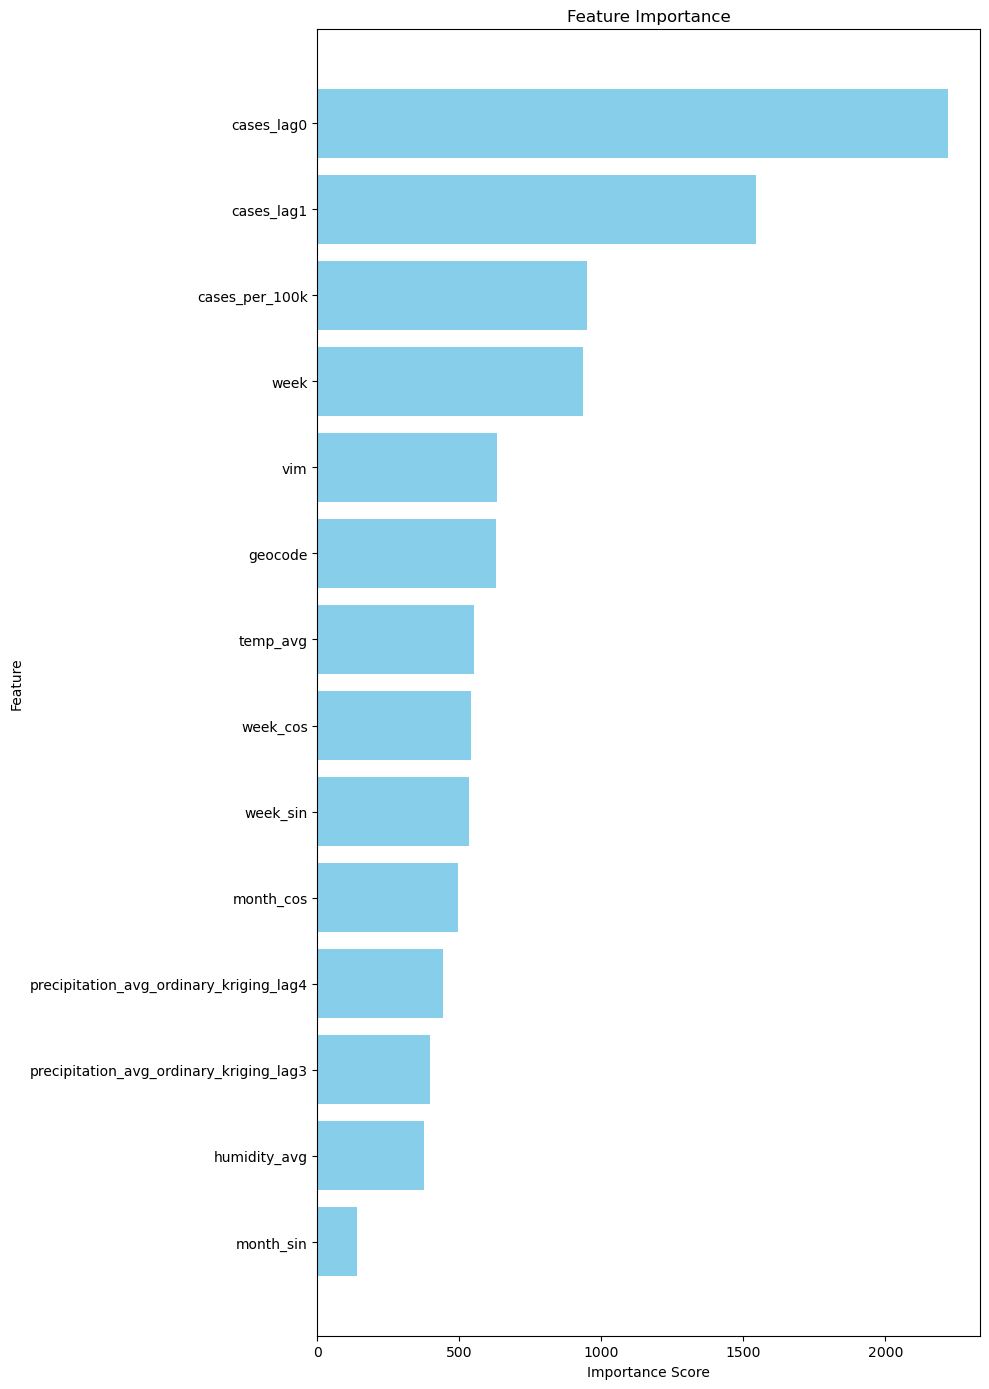

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame for feature importance
importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importance()
})

# Sort by importance
importance = importance.sort_values(by='Importance', ascending=False)

# Print top features in a neat table
print("Top 10 Most Important Features:")
print(importance.head(10))

# Visualize feature importance
plt.figure(figsize=(10, 14))
plt.barh(importance['Feature'], importance['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.tight_layout()
plt.show()


RMSE: 10.429339520885593


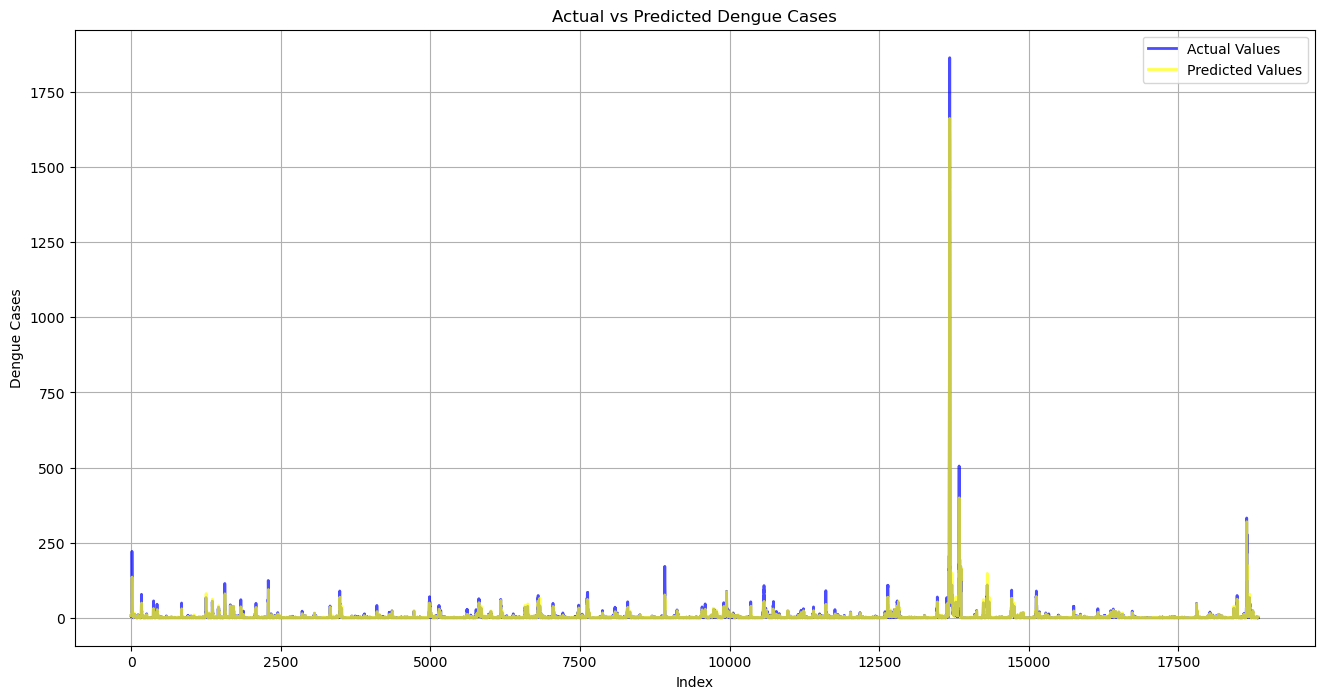

In [27]:
# Step 1: Reshape the actual target values to match the shape of predictions
y_actual = target_scaler.inverse_transform(y_test)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
print(f'RMSE: {rmse}')

# Step 2: Plot the graph
plt.figure(figsize=(16, 8))
plt.plot(np.arange(len(y_actual)), y_actual, label='Actual Values', color='blue', alpha=0.7, linewidth=2)
plt.plot(np.arange(len(y_pred)), y_pred, label='Predicted Values', color='yellow', alpha=0.7, linewidth=2)
plt.xlabel('Index')
plt.ylabel('Dengue Cases')
plt.title('Actual vs Predicted Dengue Cases')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
import joblib

# ✅ Save the scalers and model
joblib.dump(feature_scaler, "feature_scaler.pkl")
joblib.dump(target_scaler, "target_scaler.pkl")
joblib.dump(model, "model.pkl")

['model.pkl']

In [29]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Optional: Get predictions on training set if not already done
train_scaled_predictions = model.predict(X_train, num_iteration=model.best_iteration)
y_train_pred = target_scaler.inverse_transform(train_scaled_predictions.reshape(-1, 1))
y_train_pred = np.clip(y_train_pred, 0, None)
y_train = target_scaler.inverse_transform(y_train)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
test_mae = mean_absolute_error(y_actual, y_pred)
test_r2 = r2_score(y_actual, y_pred)

# ===== Create Evaluation Summary Table =====
evaluation_results = {
    '': ['Global - Train', 'Global - Test'],
    'RMSE': [train_rmse, test_rmse],
    'MAE': [train_mae, test_mae],
    'R²': [train_r2, test_r2]
}

results_df = pd.DataFrame(evaluation_results)
print("\n===== Evaluation Metrics Table =====")
print(results_df.to_string(index=False))


===== Evaluation Metrics Table =====
                    RMSE      MAE       R²
Global - Train 72.213771 6.509601 0.923304
 Global - Test 10.429340 2.282764 0.925244


City: 3300100, RMSE: 15.286846415725824


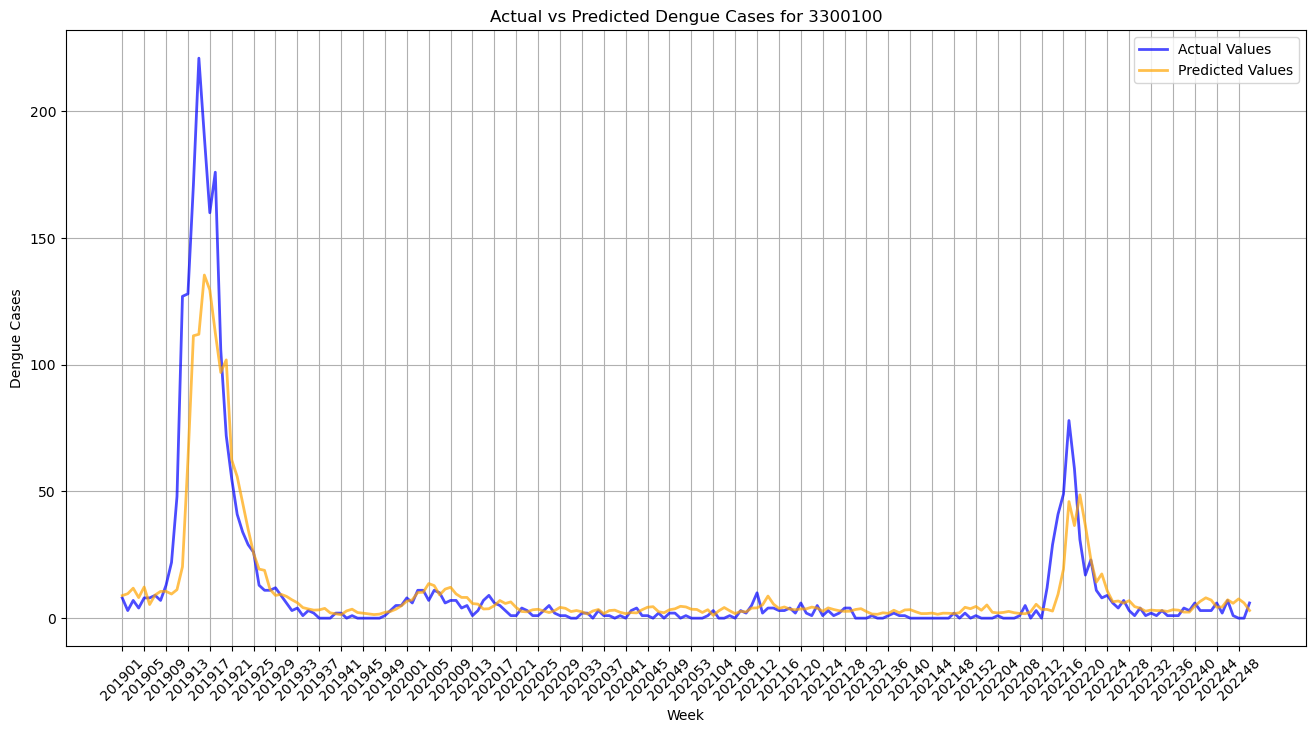

In [30]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'city_encoded' and 'week' are present in X_test
cities = X_test['geocode'].unique()
limit = 1
count = 0

for geocode in cities:
    # Filter data for the geocode
    city_indices = X_test['geocode'] == geocode
    y_actual_city = y_actual[city_indices]
    y_pred_city = y_pred[city_indices]

    # Get weeks for the geocode and convert them to strings
    weeks_city = X_test['week'][city_indices].astype(str)

    # # Skip the geocode if the maximum actual dengue cases are less than 10
    if np.max(y_actual_city) < 10:
        continue
        
    count += 1
    
    if count > limit:
        break

    # Compute RMSE for the geocode
    rmse_city = np.sqrt(mean_squared_error(y_actual_city, y_pred_city))
    print(f'City: {geocode}, RMSE: {rmse_city}')

    # Plot for the geocode with weeks on the x-axis
    plt.figure(figsize=(16, 8))
    plt.plot(weeks_city, y_actual_city, label='Actual Values', color='blue', alpha=0.7, linewidth=2)
    plt.plot(weeks_city, y_pred_city, label='Predicted Values', color='orange', alpha=0.7, linewidth=2)
    plt.xlabel('Week')
    plt.ylabel('Dengue Cases')
    plt.title(f'Actual vs Predicted Dengue Cases for {geocode}')
    plt.legend()
    plt.grid(True)

    # Select every 4th week for x-axis labels
    ticks = weeks_city[::4]  # Select every 4th week
    plt.xticks(ticks, rotation=45)  # Rotate x-axis labels for readability
    plt.show()


In [31]:
import pandas as pd
import numpy as np
import json

# Load geocode mapping
with open("data/city_mapping.json", "r", encoding='utf-8') as f:
    city_geocode_map = json.load(f)

# Flatten y_pred and y_actual in case they are 2D (e.g., shape: (n, 1))
y_pred = np.ravel(y_pred)
y_actual = np.ravel(y_actual)

# Make sure X_test['geocode'] and X_test['week'] are Series
city_series = pd.Series(X_test['geocode'].values, name='geocode')
week_series = pd.Series(X_test['week'].values, name='week')

# Create DataFrame
df = pd.DataFrame({
    'geocode': city_series,
    'week': week_series,
    'lightgbm_predict': y_pred,
    'actual': y_actual
})

df['actual'] = df['actual'].astype(int)

# Extract year from week (assuming YYYYWW format)
df['year'] = df['week'].astype(str).str[:4]

# Save predictions for 2019
df_2019 = df[df['year'] == '2019'][['geocode', 'week', 'lightgbm_predict', 'actual']]
df_2019.to_csv("predictions_2019.csv", index=False)

# Save predictions for 2020
df_2020 = df[df['year'] == '2020'][['geocode', 'week', 'lightgbm_predict', 'actual']]
df_2020.to_csv("predictions_2020.csv", index=False)

# Save predictions for 2021
df_2021 = df[df['year'] == '2021'][['geocode', 'week', 'lightgbm_predict', 'actual']]
df_2021.to_csv("predictions_2021.csv", index=False)

# Save predictions for 2022
df_2022 = df[df['year'] == '2022'][['geocode', 'week', 'lightgbm_predict', 'actual']]
df_2022.to_csv("predictions_2022.csv", index=False)